<a href="https://colab.research.google.com/github/Stopfield/TransferLearningDIO/blob/main/transfer_learning_dio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aplicando o Transfer Learning com o modelo VGG16
Usando o que aprendemos no curso somado ao exemplo dado, podemos usar a biblioteca `keras` para criar uma rede neural que resolva um simples problema de classificação visual. O trabalho usa o método de *Feature Extraction*, onde somente a última camada da rede é alterada. Isso parte da hipótese de que a rede já aprendeu formas elementares, mais abstratas, para classificação correta.

Vamos usar o dataset Cats_vs_Dogs encontrado aqui: https://www.tensorflow.org/datasets/catalog/cats_vs_dogs?hl=pt-br

Nosso modelo deverá classificar corretamente a imagem de gatos e cães.

In [ ]:
%matplotlib inline

import os

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

## Processamento dos dados
Nessa etapa, vamos baixar os dados e colocá-los em um formato compatível com a rede neural.

Vamos baixar o dataset de teste usando `curl` e `unzip`. O dataset vem no formato `zip`, por isso vamos usar o segundo comando.

In [34]:
!echo "Baixando dataset cats_and_dogs..."
!curl --output cats_and_dogs --progress-bar https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -qq cats_and_dogs
!ls

Baixando dataset cats_and_dogs...
############################################################################################# 100.0%
replace PetImages/Cat/10014.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 bob.jpg	 CDLA-Permissive-2.0.pdf   model_new.keras  'readme[1].txt'
 cats_and_dogs	 fuligem.png		   PetImages	     sample_data


In [ ]:
# Vamos primeiro pegar as classes
root = 'PetImages'
train_split, test_split = 0.75, 0.15

# Vamos andar pelo diretório e encontrar as pastas
categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['PetImages/Dog', 'PetImages/Cat']


In [ ]:
# Definindo a função de pegar a imagem e sua classe
# Um try foi colocado porque algumas imagens estavam dando erro
def get_image(path: str):
  try:
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) # Transforma em uma array 2D
    x = preprocess_input(x)
    return img, x
  except (IOError, OSError) as e:
    print(f"Error loading image from path: {path}")
    print(f"Error details: {e}")
    return None, None

Antes de carregarmos a imagem, o dataset total contém muitas instâncias, mais de 10000. Isso quebra o Collab por falta de RAM. Por isso, vamos remover 7/8 de cada classe do Dataset. Para isso, vamos executar a seguinte função.

In [ ]:
def remove_half(path):
  diretorio = path

  # Obtém a lista de arquivos no diretório
  arquivos = [f for f in os.listdir(diretorio) if os.path.isfile(os.path.join(diretorio, f))]

  # Embaralha a lista de arquivos para garantir uma seleção aleatória
  random.shuffle(arquivos)

  # Calcula quantos arquivos serão removidos (metade do total)
  quantidade_para_remover = len(arquivos) // 2

  # Seleciona a primeira metade dos arquivos
  arquivos_para_remover = arquivos[:quantidade_para_remover]

  # Remove os arquivos selecionados
  for arquivo in arquivos_para_remover:
      caminho_arquivo = os.path.join(diretorio, arquivo)
      os.remove(caminho_arquivo)

  print(f'{quantidade_para_remover} arquivos foram removidos de "{diretorio}".')

# Vamos executar duas vezes para cada classe:
for c, category in enumerate(categories):
  remove_half(category)
  remove_half(category)
  remove_half(category)

6250 arquivos foram removidos de "PetImages/Dog".
3125 arquivos foram removidos de "PetImages/Dog".
1563 arquivos foram removidos de "PetImages/Dog".
6250 arquivos foram removidos de "PetImages/Cat".
3125 arquivos foram removidos de "PetImages/Cat".
1563 arquivos foram removidos de "PetImages/Cat".


In [ ]:
print('Total de imagens por classe:')
for c, category in enumerate(categories):
  print(f'{category}: {len(os.listdir(category))}')

Total de imagens por classe:
PetImages/Dog: 1563
PetImages/Cat: 1563


Agora vamos carregar todas as imagens.

In [ ]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
      img, x = get_image(img_path)
      if x is not None:
        data.append({'x':np.array(x[0]), 'y':c})

num_classes = len(categories)

In [ ]:
print(f'Total de instâncias: {len(data)}')

Total de instâncias: 3125


In [ ]:
random.shuffle(data)

In [ ]:
# Divide em Treino, Teste e Validação
idx_val = int(train_split * len(data))
idx_test = int((train_split + test_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [ ]:
print(f'Treino: {len(train)}')
print(f'Teste: {len(test)}')
print(f'Validação: {len(val)}')

Treino: 2343
Teste: 313
Validação: 469


In [ ]:
# Vamos pegar agora as instâncias e suas classificações (0 para cão, 1 para gato)
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1]


In [ ]:
# Vamos normalizar os dados
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Precisamos definir as variáveis como categóricas
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# Um sumário retirado do exemplo
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 3125 images from 2 categories
train / validation / test split: 2343, 469, 313
training data shape:  (2343, 224, 224, 3)
training labels shape:  (2343, 2)


Agora vamos plottar algumas imagens para confirmar

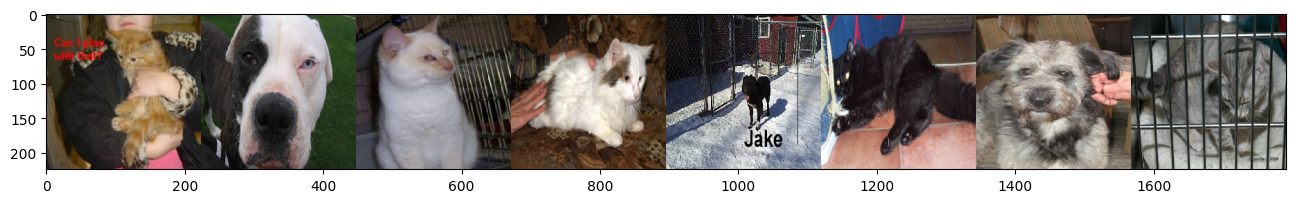

In [ ]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

## Transfer Learning usando o VGG16
Com os dados prontos, podemos utilizar nosso modelo pré-treinado e adaptá-lo.

In [ ]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# make a reference to VGG's input layer
inp = vgg.input

# Criando nossa nova layer para 2 classes
new_classification_layer = Dense(num_classes, activation='softmax')

# Conectando nossa layer
out = new_classification_layer(vgg.layers[-2].output)

# E criando um modelo entre inp a out
model_new = Model(inp, out)

In [ ]:
# Para deixar as outras camadas estáticas, é só mudar uma flag
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# Mas a última deve ser treinável
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [ ]:
# Alivia a RAM
del images
del idx
del imgs
del concat_image
gc.collect()

36

In [ ]:
# vamos salvar o modelo, para caso a RAM acaabe
model_new.save('model_new.keras')

In [ ]:
model_new = keras.models.load_model('model_new.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 6 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.5431 - loss: 0.8642 - val_accuracy: 0.8401 - val_loss: 0.4753
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 63s 642ms/step - accuracy: 0.8147 - loss: 0.4518 - val_accuracy: 0.8721 - val_loss: 0.3652
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 638ms/step - accuracy: 0.8604 - loss: 0.3705 - val_accuracy: 0.8913 - val_loss: 0.3258
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 638ms/step - accuracy: 0.8792 - loss: 0.3256 - val_accuracy: 0.8955 - val_loss: 0.2861
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 653ms/step - accuracy: 0.8777 - loss: 0.3060 - val_accuracy: 0.8870 - val_loss: 0.2804
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 636ms/step - accuracy: 0.8812 - loss: 0.2962 - val_accuracy: 0.8827 - val_loss: 0.2783
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 663ms/step - accuracy: 0.8830 - loss: 0.2768 - val_accuracy: 0.9041 - val_loss: 0.2469
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 644ms/step - accuracy: 0.9131 - loss: 0.2515 - val_accurac

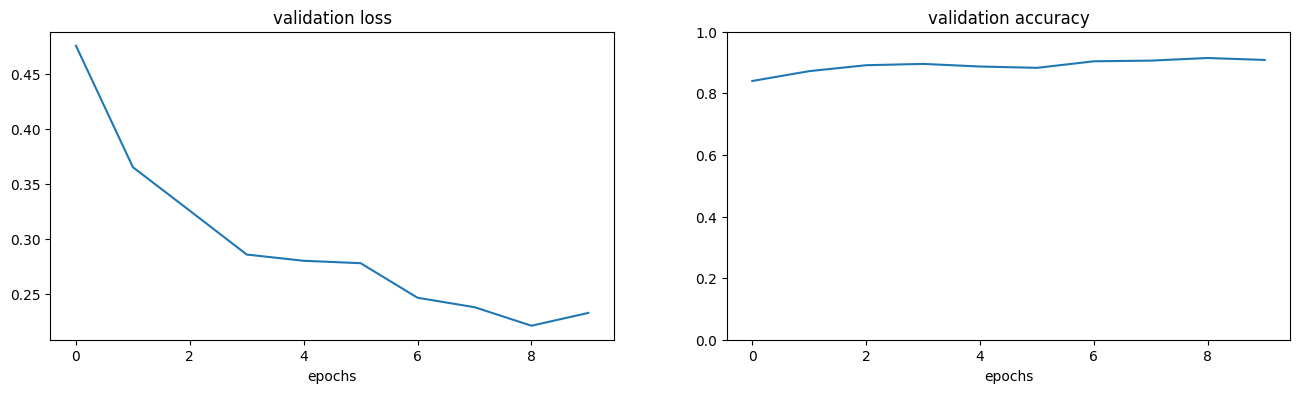

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history2.history['val_accuracy'])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

# Vamos testar algumas imagens que eu mesmo dei upload

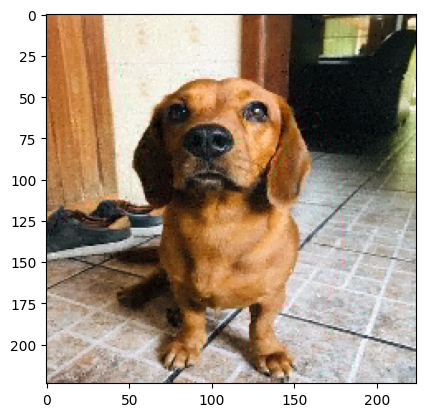

In [ ]:
bob_img = image.load_img('bob.jpg', target_size=(224, 224))
plt.imshow(np.asarray(bob_img))
plt.show()

In [ ]:
img, x = get_image('bob.jpg')
probabilities = model_new.predict([x])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [ ]:
print('Dog: ', int(probabilities[0][0]))
print('Cat: ', int(probabilities[0][1]))

Dog:  1
Cat:  0


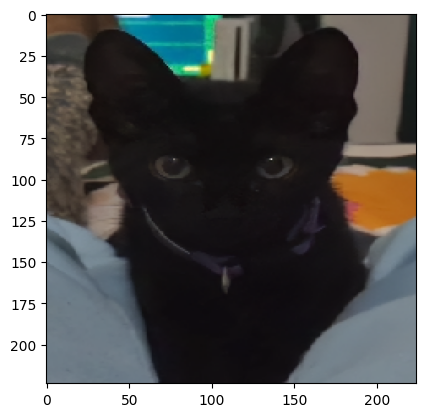

In [ ]:
bob_img = image.load_img('fuligem.png', target_size=(224, 224))
plt.imshow(np.asarray(bob_img))
plt.show()

In [ ]:
img, x = get_image('fuligem.png')
probabilities = model_new.predict([x])
print('Dog: ', int(probabilities[0][0]))
print('Cat: ', int(probabilities[0][1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Dog:  0
Cat:  1
